In [1]:
## Callin Switzer
## 2 Nov 2017
## Capture Images from pt grey camera

In [5]:
# setup arduino
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import datetime

import PyCapture2 as fc2
from sys import exit

import time

import os
import peakutils 
import msvcrt
import winsound
import shutil
import pandas as pd

import skimage.io as io

In [6]:
# capture image with point grey camera
bus = fc2.BusManager()
numCams = bus.getNumOfCameras()
print("Number of cameras detected: ", numCams)
if not numCams:
    print("Insufficient number of cameras. Exiting...")
    exit()
    
# Select camera on 0th index
c = fc2.Camera()
c.connect(bus.getCameraFromIndex(0))

Number of cameras detected:  1


In [6]:
def enableEmbeddedTimeStamp(cam, enableTimeStamp):
    embeddedInfo = cam.getEmbeddedImageInfo()
    if embeddedInfo.available.timestamp:
        cam.setEmbeddedImageInfo(timestamp = enableTimeStamp)
        if(enableTimeStamp):
            print("\nTimeStamp is enabled.\n")
        else:
            print("\nTimeStamp is disabled.\n")

enableEmbeddedTimeStamp(c, True)


TimeStamp is enabled.



In [7]:
def grabImages(cam, numImagesToGrab):
    prevts = None
    for i in range(numImagesToGrab):
        try:
            image = cam.retrieveBuffer()
        except fc2.Fc2error as fc2Err:
            print("Error retrieving buffer : ", fc2Err)
            continue

        ts = image.getTimeStamp()
        if (prevts):
            diff = (ts.cycleSeconds - prevts.cycleSeconds) * 8000 + (ts.cycleCount - prevts.cycleCount)
            print("timestamp [", ts.cycleSeconds, ts.cycleCount, "] -", diff)
        prevts = ts

#     print("Saving the last image to fc2CustomImageEx.png")
#     image.save("fc2CustomImageEx.png".encode("utf-8"), PyCapture2.IMAGE_FILE_FORMAT.PNG)

    return(image)

In [8]:
c.startCapture()

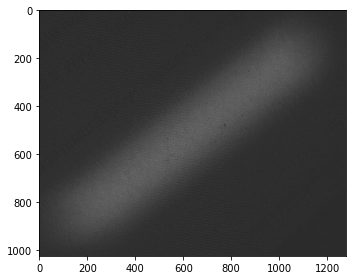

In [17]:
img = grabImages(c, 1)

cv_image = np.array(img.getData(), dtype="uint8").reshape( (img.getRows(), img.getCols()) );
io.imshow(cv_image)

In [19]:
def checkSoftwareTriggerPresence(cam):
    triggerInq = 0x530
    if(cam.readRegister(triggerInq) & 0x10000 != 0x10000):
        return False
    return True


if not checkSoftwareTriggerPresence(c):
    print("SOFT_ASYNC_TRIGGER not implemented on this Camera! Stopping application")
    exit()

In [20]:
checkSoftwareTriggerPresence(c)

True

PyCapture2 library version: 2 11 3 164

Number of cameras detected:  1

*** CAMERA INFORMATION ***

Serial number -  16061221
Camera model -  b'Chameleon3 CM3-U3-13Y3C'
Camera vendor -  b'Point Grey Research'
Sensor -  b'OnSemi PYTHON1300 (1/2" Color CMOS)'
Resolution -  b'1280x1024'
Firmware version -  b'1.9.3.0'
Firmware build time -  b'Mon Jul 27 20:45:52 2015'


Press the Enter key to initiate a software trigger



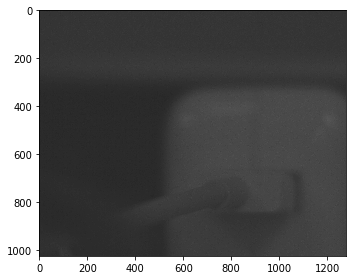

.

Press the Enter key to initiate a software trigger



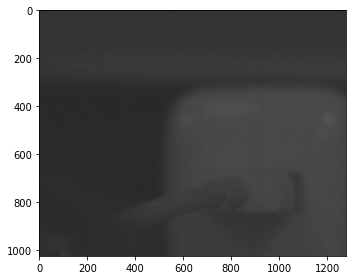

.

Press the Enter key to initiate a software trigger



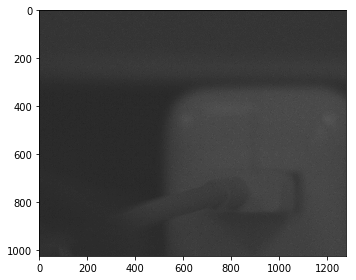

.

Press the Enter key to initiate a software trigger



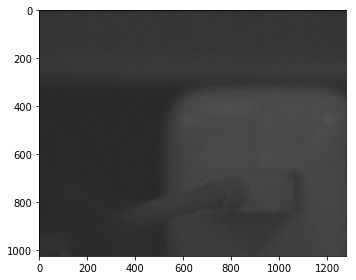

.

Press the Enter key to initiate a software trigger



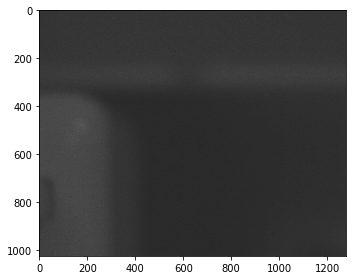

.

Press the Enter key to initiate a software trigger



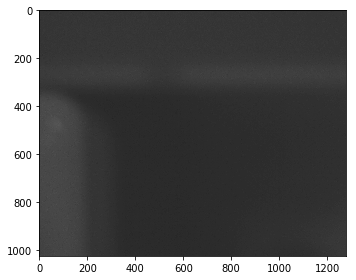

.

Press the Enter key to initiate a software trigger



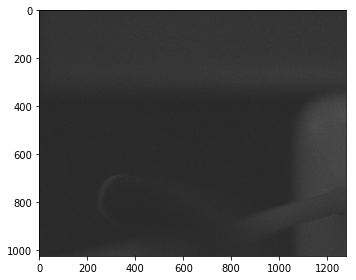

.

Press the Enter key to initiate a software trigger



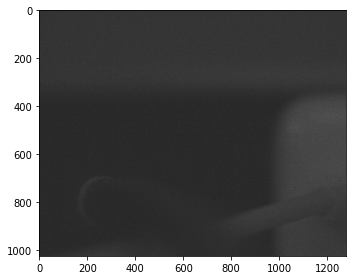

.

Press the Enter key to initiate a software trigger



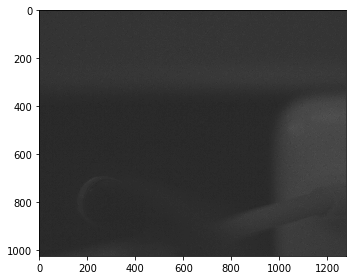

.

Press the Enter key to initiate a software trigger



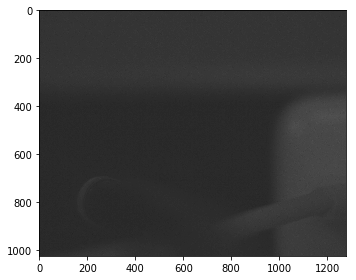

.
Finished grabbing images!
Done! Press Enter to exit...



''

In [27]:
# example asynchronous trigger
#=============================================================================
# Copyright 2017 FLIR Integrated Imaging Solutions, Inc. All Rights Reserved.
#
# This software is the confidential and proprietary information of FLIR
# Integrated Imaging Solutions, Inc. ("Confidential Information"). You
# shall not disclose such Confidential Information and shall use it only in
# accordance with the terms of the license agreement you entered into
# with FLIR Integrated Imaging Solutions, Inc. (FLIR).
#
# FLIR MAKES NO REPRESENTATIONS OR WARRANTIES ABOUT THE SUITABILITY OF THE
# SOFTWARE, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR
# PURPOSE, OR NON-INFRINGEMENT. FLIR SHALL NOT BE LIABLE FOR ANY DAMAGES
# SUFFERED BY LICENSEE AS A RESULT OF USING, MODIFYING OR DISTRIBUTING
# THIS SOFTWARE OR ITS DERIVATIVES.
#=============================================================================

import PyCapture2
from sys import exit
from time import sleep

def printBuildInfo():
    libVer = PyCapture2.getLibraryVersion()
    print("PyCapture2 library version:", libVer[0], libVer[1], libVer[2], libVer[3])
    print()

def printCameraInfo(cam):
    camInfo = cam.getCameraInfo()
    print("\n*** CAMERA INFORMATION ***\n")
    print("Serial number - ", camInfo.serialNumber)
    print("Camera model - ", camInfo.modelName)
    print("Camera vendor - ", camInfo.vendorName)
    print("Sensor - ", camInfo.sensorInfo)
    print("Resolution - ", camInfo.sensorResolution)
    print("Firmware version - ", camInfo.firmwareVersion)
    print("Firmware build time - ", camInfo.firmwareBuildTime)
    print()

def checkSoftwareTriggerPresence(cam):
    triggerInq = 0x530
    if(cam.readRegister(triggerInq) & 0x10000 != 0x10000):
        return False
    return True

def pollForTriggerReady(cam):
    softwareTrigger = 0x62C
    while True:
        regVal = cam.readRegister(softwareTrigger)
        if not regVal:
            break

def fireSoftwareTrigger(cam):
    softwareTrigger = 0x62C
    fireVal = 0x80000000
    cam.writeRegister(softwareTrigger, fireVal)

#
# Example Main
#

# Print PyCapture2 Library Information
printBuildInfo()

# Ensure sufficient cameras are found
bus = PyCapture2.BusManager()
numCams = bus.getNumOfCameras()
print("Number of cameras detected: ", numCams)
if not numCams:
    print("Insufficient number of cameras. Exiting...")
    exit()

c = PyCapture2.Camera()
c.connect(bus.getCameraFromIndex(0))

# Power on the Camera
cameraPower = 0x610
powerVal = 0x80000000

c.writeRegister(cameraPower, powerVal)

# Waiting for Camera to power up
retries = 10
timeToSleep = 0.1    # seconds
for i in range(retries):
    sleep(timeToSleep)
    try:
        regVal = c.readRegister(cameraPower)
    except PyCapture2.Fc2error:    # Camera might not respond to register reads during powerup.
        pass
    awake = True
    if regVal == powerVal:
        break
    awake = False
if not awake:
    print("Could not wake Camera. Exiting...")
    exit()

# Print camera details
printCameraInfo(c)

# Configure trigger mode
triggerMode = c.getTriggerMode()
triggerMode.onOff = True
triggerMode.mode = 0
triggerMode.parameter = 0
triggerMode.source = 7        # Using software trigger

c.setTriggerMode(triggerMode)

pollForTriggerReady(c)

c.setConfiguration(grabTimeout = 5000)

# Start acquisition
c.startCapture()

if not checkSoftwareTriggerPresence(c):
    print("SOFT_ASYNC_TRIGGER not implemented on this Camera! Stopping application")
    exit()

# Grab images
numImages = 10
for i in range(numImages):
    pollForTriggerReady(c)
    print("\nPress the Enter key to initiate a software trigger")
    input()
    fireSoftwareTrigger(c)
    try:
        image = c.retrieveBuffer()
        cv_image = np.array(image.getData(), dtype="uint8").reshape( (image.getRows(), image.getCols()) );
        io.imshow(cv_image)
        plt.show()
    except PyCapture2.Fc2error as fc2Err:
        print("Error retrieving buffer : ", fc2Err)
        continue

    print(".")

c.setTriggerMode(onOff = False)


print("Finished grabbing images!")

c.stopCapture()
c.disconnect()

input("Done! Press Enter to exit...\n")


In [34]:
# record short movie
def saveAviHelper(cam, fileFormat, fileName, frameRate):
    numImages = 100

    avi = PyCapture2.AVIRecorder()

    for i in range(numImages):
        try:
            image = cam.retrieveBuffer()
        except PyCapture2.Fc2error as fc2Err:
            print("Error retrieving buffer : ", fc2Err)
            continue

        print("Grabbed image {}".format(i))

        if (i == 0):
            if fileFormat == "AVI":
                avi.AVIOpen(fileName, frameRate)
            elif fileFormat == "MJPG":
                avi.MJPGOpen(fileName, frameRate, 75)
            elif fileFormat == "H264":
                avi.H264Open(fileName, frameRate, image.getCols(), image.getRows(), 1000000)
            else:
                print("Specified format is not available.")
                return

        avi.append(image)
        print("Appended image {}...".format(i))

    print("Appended {} images to {} file: {}...".format(numImages, fileFormat, fileName))
    avi.close()


# Select camera on 0th index
cam = PyCapture2.Camera()
cam.connect(bus.getCameraFromIndex(0))

# Print camera details
printCameraInfo(cam)

print("Starting capture...")
cam.startCapture()

fRateProp = cam.getProperty(PyCapture2.PROPERTY_TYPE.FRAME_RATE)
frameRate = fRateProp.absValue
print("Using frame rate of {}".format(frameRate))
for fileFormat in ("AVI","H264","MJPG"):
    fileName = "SaveImageToAviEx_{}.avi".format(fileFormat)
    saveAviHelper(cam, fileFormat, fileName.encode("utf-8"), frameRate)

print("Stopping capture...")
cam.stopCapture()
cam.disconnect()


*** CAMERA INFORMATION ***

Serial number -  16061221
Camera model -  b'Chameleon3 CM3-U3-13Y3C'
Camera vendor -  b'Point Grey Research'
Sensor -  b'OnSemi PYTHON1300 (1/2" Color CMOS)'
Resolution -  b'1280x1024'
Firmware version -  b'1.9.3.0'
Firmware build time -  b'Mon Jul 27 20:45:52 2015'

Starting capture...
Using frame rate of 26.65596580505371
Grabbed image 0
Appended image 0...
Grabbed image 1
Appended image 1...
Grabbed image 2
Appended image 2...
Grabbed image 3
Appended image 3...
Grabbed image 4
Appended image 4...
Grabbed image 5
Appended image 5...
Grabbed image 6
Appended image 6...
Grabbed image 7
Appended image 7...
Grabbed image 8
Appended image 8...
Grabbed image 9
Appended image 9...
Grabbed image 10
Appended image 10...
Grabbed image 11
Appended image 11...
Grabbed image 12
Appended image 12...
Grabbed image 13
Appended image 13...
Grabbed image 14
Appended image 14...
Grabbed image 15
Appended image 15...
Grabbed image 16
Appended image 16...
Grabbed image 17
Ap

In [47]:
cam = PyCapture2.Camera()
cam.connect(bus.getCameraFromIndex(0))
bb = cam.getTriggerMode()
dir(bb)
print(bb.mode)
print(bb.onOff)
print(bb.source)

0
False
7


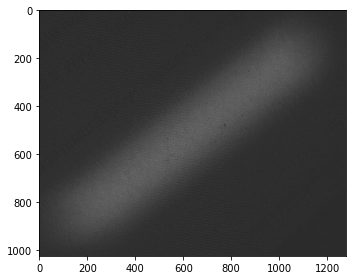

In [23]:
cv_image = np.array(img.getData(), dtype="uint8").reshape( (img.getRows(), img.getCols()) );
io.imshow(cv_image)

In [2]:
# live preview
